### Clean all data together so that the categorical conversion is applicable.!

In [57]:
import pandas as pd
import json
from pandas import json_normalize

df=pd.read_csv(r'./feature_importance/feature_imp_data.csv',header=[0])
print(df.shape)
df.head(2)

(8244, 10)


,transmission,model,Year of Manufacture,City,ft,bt,Ownership,Kms Driven,Engine Type,price
0,1,160,2015.0,0,4,2,4,120000.0,293,400000.0
1,1,50,2018.0,0,4,7,3,32706.0,396,811000.0


In [58]:
import numpy as np

# Calculate mean and standard deviation for price
mean_price = df['price'].mean()
std_price = df['price'].std()

# Define 3-sigma bounds
lower_bound = mean_price - 3 * std_price
upper_bound = mean_price + 3 * std_price

# Filter the DataFrame to keep only rows within 3-sigma range
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"Filtered data within 3-sigma range for 'price': {lower_bound:.2f} to {upper_bound:.2f}")

Filtered data within 3-sigma range for 'price': -3273232.22 to 5191793.76


In [59]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pickle

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

print(df_normalized)
df_normalized.head()

# Save the scaler to a pickle file
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler saved to minmax_scaler.pkl")


      transmission     model  Year of Manufacture  City    ft   bt  Ownership  \
0              1.0  0.507987             0.619048   0.0  1.00  0.2        0.8   
1              1.0  0.156550             0.761905   0.0  1.00  0.7        0.6   
2              1.0  0.869010             0.761905   0.0  1.00  0.2        0.2   
3              1.0  0.274760             0.571429   0.0  1.00  0.8        0.2   
4              1.0  0.565495             0.619048   0.0  0.25  0.7        0.2   
...            ...       ...                  ...   ...   ...  ...        ...   
8086           1.0  0.507987             0.952381   1.0  1.00  0.2        0.2   
8087           1.0  0.492013             0.571429   1.0  1.00  0.2        0.2   
8088           0.0  0.626198             0.428571   1.0  1.00  0.8        0.8   
8089           1.0  0.555911             0.476190   1.0  1.00  0.2        0.2   
8090           1.0  0.750799             0.714286   1.0  0.25  0.7        0.6   

      Kms Driven  Engine Ty

In [60]:
# Scaling parameters
print("Scale factors (1 / (max - min)):\n", scaler.scale_)   # Array of scale factors
print("Min offsets (used in transform):\n", scaler.min_)     # Array of min transform offsets

Scale factors (1 / (max - min)):
 [1.00000000e+00 3.19488818e-03 4.76190476e-02 2.00000000e-01
 2.50000000e-01 1.00000000e-01 2.00000000e-01 1.81824794e-07
 1.96850394e-03 1.93723363e-07]
Min offsets (used in transform):
 [ 0.00000000e+00 -3.19488818e-03 -9.53333333e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.63649587e-05
  0.00000000e+00 -5.42425417e-03]


In [61]:
#df_original = pd.DataFrame(scaler.inverse_transform(df_normalized), columns=df.columns)

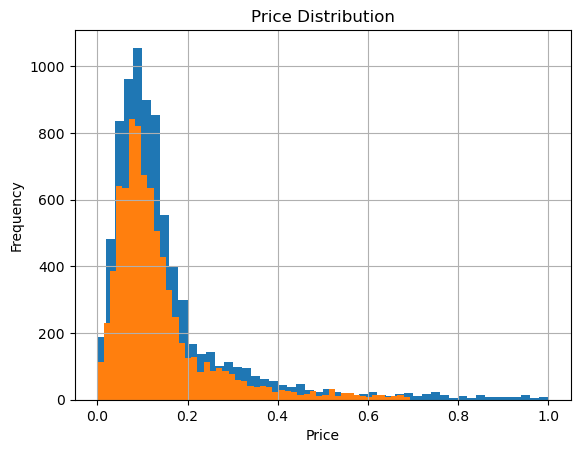

In [62]:
import matplotlib.pyplot as plt
df_normalized['price'].hist(bins=50)  # You can adjust bins as needed
np.log1p(df_normalized['price']).hist(bins=50)
#plt.xlim(1e7, 5e7)
#plt.ylim(0,10)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

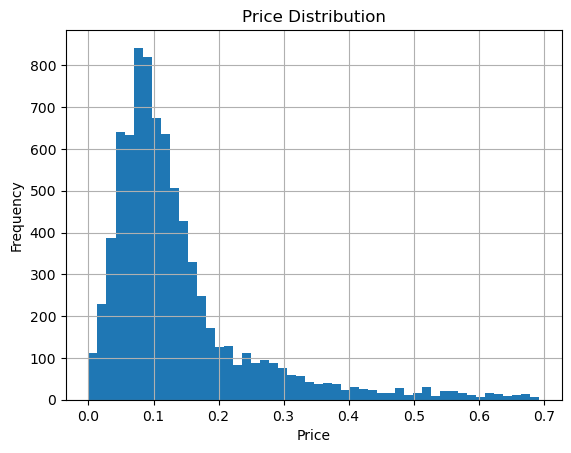

In [63]:
import matplotlib.pyplot as plt
np.log1p(df_normalized['price']).hist(bins=50)  # You can adjust bins as needed
#plt.xlim(1e7, 5e7)
#plt.ylim(0,10)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

In [64]:
#(df_normalized['price']/scaler.scale_[-1])+scaler.min_[-1]

In [65]:
df=df_normalized.copy()

In [66]:
# import numpy as np

# # Select all numeric columns including 'price'
# numeric_cols = df.select_dtypes(include=[np.number]).columns

# # Apply 3-sigma rule across all numeric columns
# for col in numeric_cols:
#     mean = df[col].mean()
#     std = df[col].std()
#     lower = mean - 3 * std
#     upper = mean + 3 * std
#     df = df[(df[col] >= lower) & (df[col] <= upper)]

# print(f"Outliers removed using 3-sigma on columns: {list(numeric_cols)}")
# print(df.shape)

In [67]:
df_x = df.drop(columns=['price'])
df_y = df[['price']]

In [68]:
print(df_x.shape)
print(df_y.shape)

(8091, 9)
(8091, 1)


### ML model for prediction: RFR

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle

# Assume df_x (input features) and df_y (target) are already defined
# Encode any categorical variables in df_x if needed
df_x_encoded = df_x.copy()

#encoder.fit(df_train)
#save fitted encoder
#load fitted encoder
#do only transform (no fit again)

label_encoders = {}

# Loop through all object (categorical) columns
for col in df_x_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_x_encoded[col] = le.fit_transform(df_x_encoded[col].astype(str))
    label_encoders[col] = le  # Save the encoder for later use

# Save all encoders to a pickle file
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("Label encoders saved to label_encoders.pkl")


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.values.ravel())

# Make predictions on train and test data
train_predictions = rf.predict(X_train)
test_predictions = rf.predict(X_test)
# Calculate evaluation metrics: MAE, MSE, R-squared
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Display the metrics
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")

Label encoders saved to label_encoders.pkl
Train MAE: 0.00876845386708372
Test MAE: 0.024757592289932087
Train MSE: 0.0003377345910525062
Test MSE: 0.002386053014629516
Train R-squared: 0.9843491298908613
Test R-squared: 0.8972783638885111


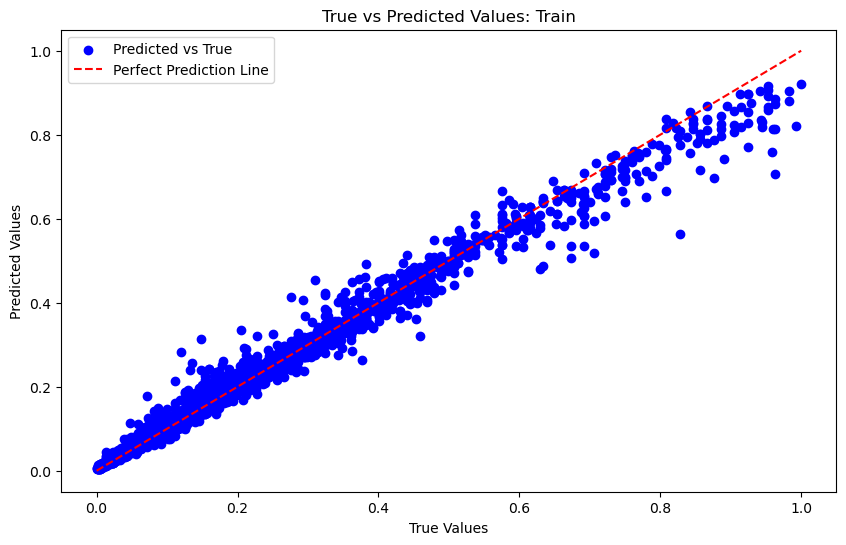

In [70]:
# Plot true vs predicted values for test set
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_train, train_predictions, color='blue', label='Predicted vs True')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values: Train')
plt.legend()
plt.show()

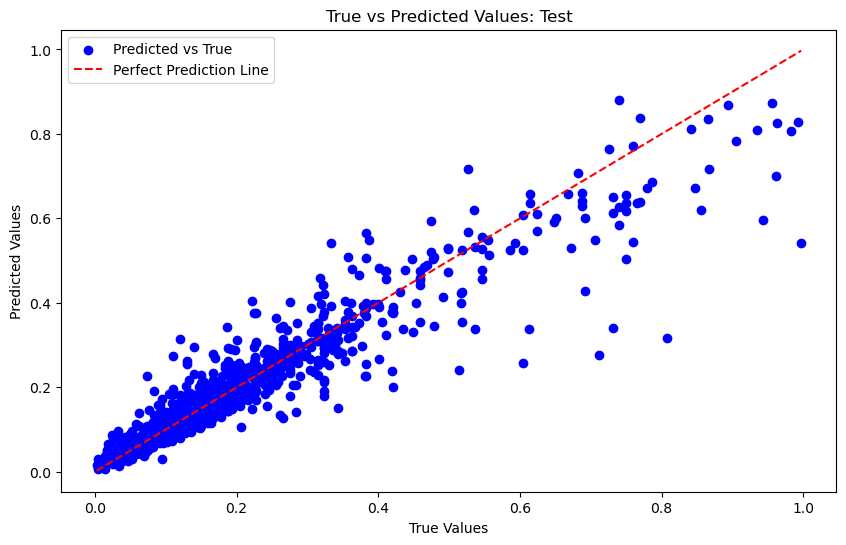

In [71]:
# Plot true vs predicted values for test set
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test, test_predictions, color='blue', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values: Test')
plt.legend()
plt.show()

### XGBoost

In [72]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assume df_x (input features) and df_y (target) are already defined
# Encode any categorical variables in df_x if needed
df_x_encoded = df_x.copy()

for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train.values.ravel())

# Make predictions on train and test data
train_predictions = xgb.predict(X_train)
test_predictions = xgb.predict(X_test)

# Calculate evaluation metrics: MAE, MSE, R-squared
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Display the metrics
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")


Train MAE: 0.011159385554492474
Test MAE: 0.023682234808802605
Train MSE: 0.0002856120700016618
Test MSE: 0.002139504998922348
Train R-squared: 0.9867645502090454
Test R-squared: 0.9078924655914307


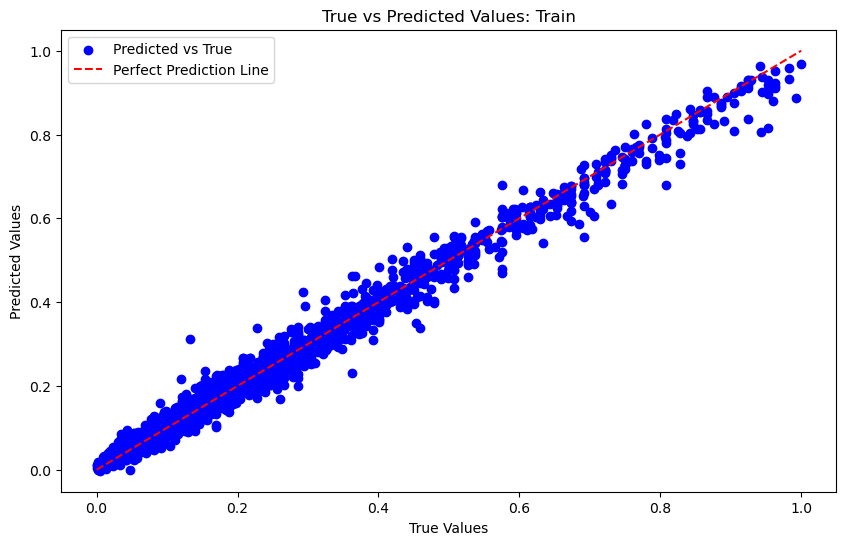

In [73]:
# Plot true vs predicted values for test set
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_train, train_predictions, color='blue', label='Predicted vs True')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values: Train')
plt.legend()
plt.show()

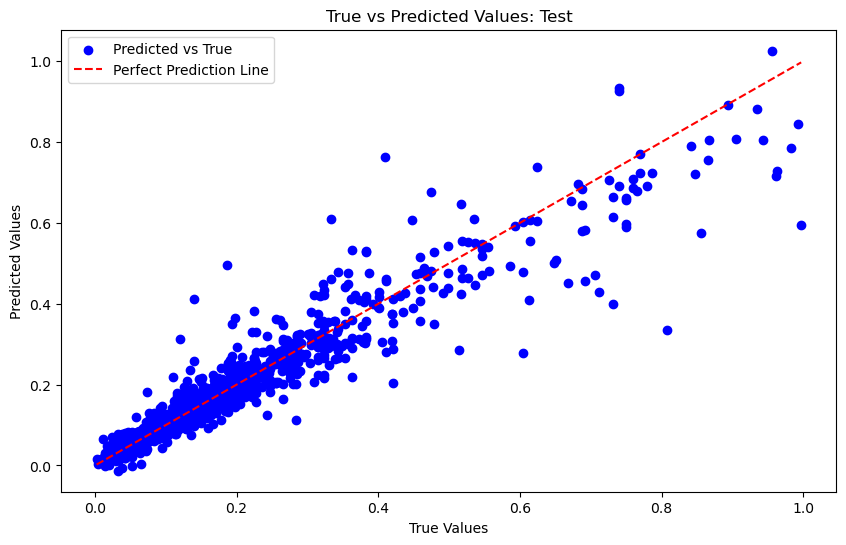

In [74]:
# Plot true vs predicted values for test set
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test, test_predictions, color='blue', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values: Test')
plt.legend()
plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Train MAE: 0.01
Train MSE: 0.00
Train R²: 0.9753

Test MAE: 0.02
Test MSE: 0.00
Test R²: 0.9091



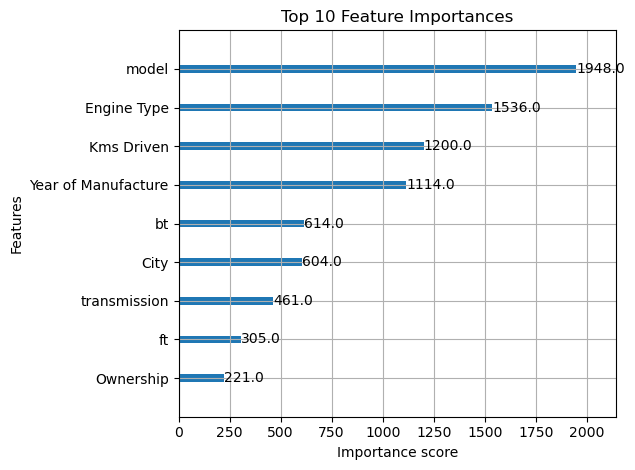

In [75]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# ------- Assume df_x and df_y are already defined -------
df_x_encoded = df_x.copy()
for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y, test_size=0.2, random_state=42)

# --------- Random search setup ----------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train.values.ravel())

# -------- Fit best model without early stopping --------
best_params = random_search.best_params_
final_model = XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42
)

final_model.fit(X_train, y_train.values.ravel())  # no early stopping

# -------- Evaluation --------
def evaluate(y_true, y_pred, dataset=''):
    print(f"{dataset} MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"{dataset} MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"{dataset} R²: {r2_score(y_true, y_pred):.4f}\n")

evaluate(y_train, final_model.predict(X_train), 'Train')
evaluate(y_test, final_model.predict(X_test), 'Test')

# -------- Feature Importance --------
from xgboost import plot_importance
plot_importance(final_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Train MAE: 0.01
Train MSE: 0.00
Train R²: 0.9728

Test MAE: 0.02
Test MSE: 0.00
Test R²: 0.9185



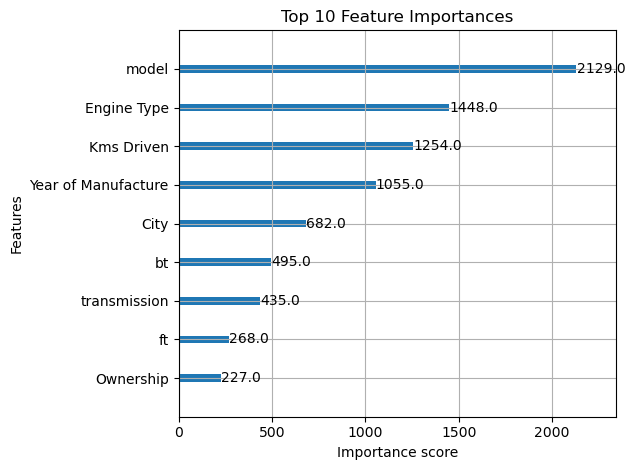

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import numpy as np

# ------------------- Combine & Remove Outliers -------------------
df = df_x.copy()
df['target'] = df_y.values

# Z-score method to detect outliers in target column
z_scores = (df['target'] - df['target'].mean()) / df['target'].std()
df_clean = df[np.abs(z_scores) < 3]  # keep only rows within 3 std devs

# Split back to features and target
df_x_clean = df_clean.drop(columns='target')
df_y_clean = df_clean[['target']]

# ------------------- Encode Categorical -------------------
df_x_encoded = df_x_clean.copy()
for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

# ------------------- Train-Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y_clean, test_size=0.2, random_state=42)

# ------------------- Hyperparameter Tuning -------------------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train.values.ravel())

# ------------------- Final Model -------------------
best_params = random_search.best_params_
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train.values.ravel())

# ------------------- Evaluation -------------------
def evaluate(y_true, y_pred, dataset=''):
    print(f"{dataset} MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"{dataset} MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"{dataset} R²: {r2_score(y_true, y_pred):.4f}\n")

evaluate(y_train, final_model.predict(X_train), 'Train')
evaluate(y_test, final_model.predict(X_test), 'Test')

# ------------------- Feature Importance -------------------
plot_importance(final_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


In [77]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ------------------- Apply Log Transformation to Target -------------------
df = df_x.copy()
df['target'] = df_y.values


# Split back to features and target
df_x_clean = df.drop(columns='target')
df_y_clean = df[['target']]

# ------------------- Encode Categorical Features -------------------
df_x_encoded = df_x_clean.copy()
for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

# ------------------- Train-Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y_clean, test_size=0.2, random_state=42)

# ------------------- Hyperparameter Tuning -------------------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 5, 10, 50]
}


random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train.values.ravel())

# ------------------- Final Model -------------------
best_params = random_search.best_params_
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train.values.ravel())

# ------------------- Predictions -------------------
# Make predictions on test data
y_pred_log = final_model.predict(X_test)

# Apply expm1 to revert log1p transformation to original scale
y_pred = np.expm1(y_pred_log)  # Inverse of log1p

# ------------------- Evaluation -------------------
def evaluate(y_true, y_pred, dataset=''):
    print(f"{dataset} MAE: {mean_absolute_error(y_true, y_pred):.7f}")
    print(f"{dataset} MSE: {mean_squared_error(y_true, y_pred):.7f}")
    print(f"{dataset} R²: {r2_score(y_true, y_pred):.7f}\n")

evaluate(np.expm1(y_test), y_pred, 'Test')  # Inverse log1p for true test values as well


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Test MAE: 0.0311838
Test MSE: 0.0055181
Test R²: 0.8918210



Fitting 3 folds for each of 10 candidates, totalling 30 fits


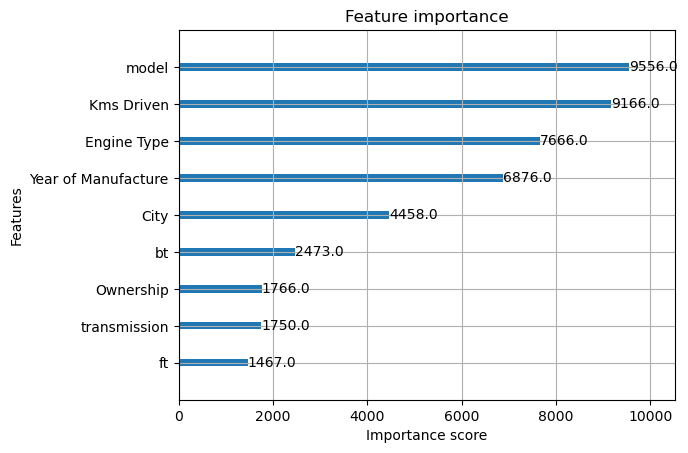

XGBoost Test MAE: 0.0371444
XGBoost Test MSE: 0.0066489
XGBoost Test R²: 0.7137587



In [78]:
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ------------------- Apply Log Transformation to Target -------------------
df = df_x.copy()
df['target'] = df_y.values

# Apply log1p (log(1 + x)) to the target to handle skewness
df['target'] = np.log1p(df['target'])

# Split back to features and target
df_x_clean = df.drop(columns='target')
df_y_clean = df[['target']]

# ------------------- Encode Categorical Features -------------------
df_x_encoded = df_x_clean.copy()
for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

# ------------------- Train-Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y_clean, test_size=0.2, random_state=42)

# ------------------- Hyperparameter Tuning -------------------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [3, 5, 7, 9, 12],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train.values.ravel())

# ------------------- Final Model -------------------
best_params = random_search.best_params_
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train.values.ravel())

# ------------------- Feature Importance -------------------
plot_importance(final_model, importance_type='weight', max_num_features=10)
plt.show()

# ------------------- Predictions -------------------
y_pred_log = final_model.predict(X_test)


# ------------------- Evaluation -------------------
def evaluate(y_true, y_pred, dataset=''):
    print(f"{dataset} MAE: {mean_absolute_error(y_true, y_pred):.7f}")
    print(f"{dataset} MSE: {mean_squared_error(y_true, y_pred):.7f}")
    print(f"{dataset} R²: {r2_score(y_true, y_pred):.7f}\n")

evaluate(np.expm1(y_test), y_pred, 'XGBoost Test')


In [79]:
import pickle

# Save the trained XGBoost model to a file
with open('price_prediction.pkl', 'wb') as file:
    pickle.dump(final_model, file)

print("price_prediction_model.pkl")


price_prediction_model.pkl


In [80]:
df_normalized.columns

Index(['transmission', 'model', 'Year of Manufacture', 'City', 'ft', 'bt',
       'Ownership', 'Kms Driven', 'Engine Type', 'price'],
      dtype='object')